## Türkçe Spam Email Veri Seti ile Model Eğitimi

Bu notebook'da bir önceki veri ile denenen modellerden başarılı olanlar Türkçe veri seti ile eğitilir.



In [44]:
import os
import pandas as pd

out_data_dir = os.path.join(os.path.dirname(os.getcwd()), "source", "data", "turkish_spam_email")

train_df = pd.read_csv(os.path.join(out_data_dir, "train.csv"))
test_df = pd.read_csv(os.path.join(out_data_dir, "test.csv"))

print(train_df.head())


   labels                                               text
0       0  haziran dönem stem eğitim sakarya ar ge proje ...
1       0  kukla toyzz ic dis ticaret website no arşiv fa...
2       0  yarişma duyuru demre ai̇hl öğretmen arasi foto...
3       1  üzer scotty kargo seçil alışveriş kargo bedava...
4       1  yılbaş özel i̇ndirimleri başlamak tl başlayan ...


## SVM Cross Validation

Burada SVM modeli cross validation ile eğitilir. 

Metinlerin vektörlerleri tf-idf ile oluşturulmuştur. 

TF-IDF ve SVM için kullanılan parametreler aşağıda verilmiştir.

| Parametre | Değer |
|-----------|-------|
| svmclass_weight | balanced |
| svmgamma | scale |
| svmkernel | rbf |
| tfidfmax_features | 5000 |
| tfidfngram_range | (1, 2) |


CV Sonuçları (5-fold)
|  | Accuracy | Precision | Recall | F1 Score |
|-----------------|----------|-----------|--------|----------|
| Ortalama | 0.9396 | 0.9492 | 0.9319 | 0.9399 |
| Standart Sapma | 0.0119 | 0.0246 | 0.0264 | 0.0120 |

Test Sonuçları
|  | Accuracy | Precision | Recall | F1 Score |
|-------------|----------|-----------|--------|----------|
| Değer | 0.9261 | 0.8981 | 0.9604 | 0.9282 |

In [45]:
import mlflow
import mlflow.sklearn
import os

# Mlflow için gerekli ayarlar yapılır
mlruns_dir = os.path.join(os.path.dirname(os.getcwd()), "mlruns")
os.makedirs(mlruns_dir, exist_ok=True)

mlflow.set_tracking_uri(f"file://{mlruns_dir}")
 
experiment_name = "SVM-CV-TR-Demo"
try:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
except Exception as e:
    print(f"MLflow ayarlanırken hata oluştu: {e}")

In [48]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import numpy as np
import joblib


def train_and_evaluate_svm_cv(train_data, test_data, dataset_name, 
                              experiment_name, result_dir, text_column='text', cv=5):
    """
    Cross validation ile SVM modelini eğitir, lokale kaydeder ve MLflow'a loglar
    """
    # MLflow deneyini ayarla
    try:
        experiment = mlflow.get_experiment_by_name(experiment_name)
        if experiment is None:
            mlflow.create_experiment(experiment_name)
        mlflow.set_experiment(experiment_name)
    except Exception as e:
        print(f"MLflow ayarlanırken hata oluştu: {e}")
    
    # En iyi parametreler
    best_params = {
        'tfidf__max_features': 5000,
        'tfidf__ngram_range': (1, 2),
        'svm__kernel': 'rbf',
        'svm__class_weight': 'balanced',
        'svm__gamma': 'scale'
    }
    
    with mlflow.start_run(run_name=f"SVM_CV_{dataset_name}"):
        # TF-IDF ve SVM modellerini oluştur
        tfidf = TfidfVectorizer(
            max_features=best_params['tfidf__max_features'],
            ngram_range=best_params['tfidf__ngram_range']
        )
        
        svm = SVC(
            kernel=best_params['svm__kernel'],
            class_weight=best_params['svm__class_weight'],
            gamma=best_params['svm__gamma']
        )
        
        X_train_tfidf = tfidf.fit_transform(train_data[text_column])
        
        # Cross validation metrikleri
        scoring = ['accuracy', 'precision', 'recall', 'f1']
        cv_results = cross_validate(
            svm, 
            X_train_tfidf,
            train_data['labels'],
            cv=cv,
            scoring=scoring,
            return_train_score=True
        )
        
        # CV metriklerini hesapla
        cv_metrics = {
            'cv_accuracy_mean': cv_results['test_accuracy'].mean(),
            'cv_accuracy_std': cv_results['test_accuracy'].std(),
            'cv_precision_mean': cv_results['test_precision'].mean(),
            'cv_precision_std': cv_results['test_precision'].std(),
            'cv_recall_mean': cv_results['test_recall'].mean(),
            'cv_recall_std': cv_results['test_recall'].std(),
            'cv_f1_mean': cv_results['test_f1'].mean(),
            'cv_f1_std': cv_results['test_f1'].std(),
        }
        
        # Final model eğitimi
        svm.fit(X_train_tfidf, train_data['labels'])
        
        # Test seti tahminleri
        X_test_tfidf = tfidf.transform(test_data[text_column])
        test_pred = svm.predict(X_test_tfidf)
        
        # Test metrikleri
        test_metrics = {
            'test_accuracy': accuracy_score(test_data['labels'], test_pred),
            'test_precision': precision_score(test_data['labels'], test_pred),
            'test_recall': recall_score(test_data['labels'], test_pred),
            'test_f1': f1_score(test_data['labels'], test_pred)
        }
        
        # Confusion Matrix
        cm = confusion_matrix(test_data['labels'], test_pred)
        plt.figure(figsize=(10,8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Normal', 'Phishing'],
                   yticklabels=['Normal', 'Phishing'])
        plt.title('Test Seti Confusion Matrix')
        plt.xlabel('Tahmin Edilen')
        plt.ylabel('Gerçek')
        
        os.makedirs(result_dir, exist_ok=True)
        cm_path = os.path.join(result_dir, f"confusion_matrix_{dataset_name}.png")
        plt.savefig(cm_path)
        mlflow.log_artifact(cm_path)
        plt.close()
        
        # MLflow'a parametreleri ve metrikleri kaydet
        mlflow.log_params({
            "dataset": dataset_name,
            "cv_folds": cv,
            **best_params
        })
        mlflow.log_metrics({**cv_metrics, **test_metrics})
        
        # MLflow'a modelleri kaydet
        mlflow.sklearn.log_model(svm, "svm_model")
        mlflow.sklearn.log_model(tfidf, "tfidf_vectorizer")
        
        
        # Model dosya yolları
        svm_path = os.path.join(result_dir, f"{dataset_name}_svm.joblib")
        tfidf_path = os.path.join(result_dir, f"{dataset_name}_tfidf.joblib")
        
        # Modelleri kaydet
        joblib.dump(svm, svm_path)
        joblib.dump(tfidf, tfidf_path)
        
        print(f"\nModeller kaydedildi:")
        print(f"SVM: {svm_path}")
        print(f"TF-IDF: {tfidf_path}")
        
        print(f"\nCV Metrikleri ({cv}-fold):")
        for metric, value in cv_metrics.items():
            print(f"{metric}: {value:.4f}")
            
        print(f"\nTest Metrikleri:")
        for metric, value in test_metrics.items():
            print(f"{metric}: {value:.4f}")
    
    return svm, tfidf, test_pred

In [8]:
# 5-fold Cross Validation
svm_model_raw, tfidf_raw, test_pred_raw = train_and_evaluate_svm_cv(
    train_data=train_df,
    test_data=test_df,
    dataset_name="raw_data_cv5",
    experiment_name=experiment_name,
    result_dir=os.path.join(os.path.dirname(os.getcwd()), "source", "models", "svm-cv","turkish","raw-cv5"),
    text_column='text',
    cv=5
)


2025/01/04 23:08:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/01/04 23:08:36 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/01/04 23:08:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Modeller kaydedildi:
SVM: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/svm-cv/turkish/raw-cv5/raw_data_cv5_svm.joblib
TF-IDF: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/svm-cv/turkish/raw-cv5/raw_data_cv5_tfidf.joblib

CV Metrikleri (5-fold):
cv_accuracy_mean: 0.9396
cv_accuracy_std: 0.0119
cv_precision_mean: 0.9492
cv_precision_std: 0.0246
cv_recall_mean: 0.9319
cv_recall_std: 0.0264
cv_f1_mean: 0.9399
cv_f1_std: 0.0120

Test Metrikleri:
test_accuracy: 0.9261
test_precision: 0.8981
test_recall: 0.9604
test_f1: 0.9282


## Logistic Regression Cross Validation

Logistic regression modeli cross validation ile eğitilir. 

Metinlerin vektörlerleri tf-idf ile oluşturulmuştur. 

TF-IDF ve Logistic Regression için kullanılan parametreler aşağıda verilmiştir.

| Parametre | Değer |
|-----------|-------|
| tfidfmax_features | 5000 |
| tfidfngram_range | (1, 2) |
| lrC | 1.0 |
| lrpenalty | l2 |
| lrmax_iter | 100 |


CV Sonuçları (5-fold)
| Metrik Türü | Accuracy | Precision | Recall | F1 Score |
|-----------------|----------|-----------|--------|----------|
| Ortalama | 0.9347 | 0.9461 | 0.9247 | 0.9350 |
| Standart Sapma | 0.0137 | 0.0235 | 0.0164 | 0.0132 |

Test Sonuçları
| Metrik Türü | Accuracy | Precision | Recall | F1 Score |
|-------------|----------|-----------|--------|----------|
| Değer | 0.9310 | 0.9143 | 0.9505 | 0.9320 |

In [49]:
import mlflow
import mlflow.sklearn
import os

# Mlflow için gerekli ayarlar yapılır
mlruns_dir = os.path.join(os.path.dirname(os.getcwd()), "mlruns")
os.makedirs(mlruns_dir, exist_ok=True)

mlflow.set_tracking_uri(f"file://{mlruns_dir}")
 
experiment_name = "Logistic-Regression-CV-TR-Demo"
try:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
except Exception as e:
    print(f"MLflow ayarlanırken hata oluştu: {e}")

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import mlflow

def plot_and_log_confusion_matrix(y_true, y_pred, title, filename, figsize=(10,8)):
    """
    Confusion matrix oluşturur, görselleştirir ve MLflow'a kaydeder
    """
    # Confusion matrix hesapla
    cm = confusion_matrix(y_true, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    
    plt.figure(figsize=figsize)
    
    sns.heatmap(cm, 
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=['Güvenli', 'Oltalama'],
                yticklabels=['Güvenli', 'Oltalama'])
    
    plt.title(title)
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    
    plt.savefig(filename)
    mlflow.log_artifact(filename)
    
    # Confusion matrix metriklerini MLflow'a kaydet
    mlflow.log_metrics({
        f"{title}_true_negatives": tn,
        f"{title}_false_positives": fp,
        f"{title}_false_negatives": fn,
        f"{title}_true_positives": tp
    })
    
    plt.show()
    
    # Metrikleri yazdır
    print(f"\n{title}")
    print(f"True Negatives (Güvenli doğru tahmin): {tn}")
    print(f"False Positives (Güvenli yanlış tahmin): {fp}")
    print(f"False Negatives (Oltalama yanlış tahmin): {fn}")
    print(f"True Positives (Oltalama doğru tahmin): {tp}")

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
import mlflow
import mlflow.sklearn
import joblib
import os

def train_and_evaluate_lr_tfidf(train_data, test_data, dataset_name, 
                               experiment_name, result_dir, text_column='text', cv=5):
    """
    TF-IDF ve Logistic Regression kullanarak model eğitir ve değerlendirir
    """
    if mlflow.active_run():
        mlflow.end_run()
    try:
        experiment = mlflow.get_experiment_by_name(experiment_name)
        if experiment is None:
            mlflow.create_experiment(experiment_name)
        mlflow.set_experiment(experiment_name)
    except Exception as e:
        print(f"MLflow ayarlanırken hata oluştu: {e}")
    
    tfidf_params = {
        'max_features': 5000,
        'ngram_range': (1, 2)
    }
    
    lr_params = {
        'penalty': 'l2',
        'C': 1.0,
        'solver': 'lbfgs',
        'max_iter': 2000,
        'class_weight': 'balanced',
        'tol': 0.0001
    }
    
    with mlflow.start_run(run_name=f"LogisticRegression_TR_{dataset_name}"):
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(**tfidf_params)),
            ('lr', LogisticRegression(**lr_params))
        ])
        
        scoring = ['accuracy', 'precision', 'recall', 'f1']
        cv_results = cross_validate(
            pipeline, 
            train_data[text_column],
            train_data['labels'],
            cv=cv,
            scoring=scoring,
            return_train_score=True
        )
        
        cv_metrics = {
            'cv_accuracy_mean': cv_results['test_accuracy'].mean(),
            'cv_accuracy_std': cv_results['test_accuracy'].std(),
            'cv_precision_mean': cv_results['test_precision'].mean(),
            'cv_precision_std': cv_results['test_precision'].std(),
            'cv_recall_mean': cv_results['test_recall'].mean(),
            'cv_recall_std': cv_results['test_recall'].std(),
            'cv_f1_mean': cv_results['test_f1'].mean(),
            'cv_f1_std': cv_results['test_f1'].std(),
        }
        
        pipeline.fit(train_data[text_column], train_data['labels'])
        
        test_pred = pipeline.predict(test_data[text_column])
        
        test_metrics = {
            'test_accuracy': accuracy_score(test_data['labels'], test_pred),
            'test_precision': precision_score(test_data['labels'], test_pred),
            'test_recall': recall_score(test_data['labels'], test_pred),
            'test_f1': f1_score(test_data['labels'], test_pred)
        }
        
        mlflow.log_params({
            "dataset": dataset_name,
            **tfidf_params,
            **{f"lr_{k}": v for k, v in lr_params.items()}
        })
      
        mlflow.log_metrics({**cv_metrics, **test_metrics})
        
        cm = confusion_matrix(test_data['labels'], test_pred)
        plt.figure(figsize=(10,8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Normal', 'Oltalama'],
                   yticklabels=['Normal', 'Oltalama'])
        plt.title('Test Seti Confusion Matrix')
        plt.xlabel('Tahmin Edilen')
        plt.ylabel('Gerçek')
        
        os.makedirs(result_dir, exist_ok=True)
        cm_path = os.path.join(result_dir, f"confusion_matrix_tfidf_lr_{dataset_name}.png")
        plt.savefig(cm_path)
        mlflow.log_artifact(cm_path, "confusion_matrix")
        plt.close()
        
        pipeline_path = os.path.join(result_dir, f"{dataset_name}.joblib")
        joblib.dump(pipeline, pipeline_path)
        mlflow.sklearn.log_model(pipeline, "model")
        
        print(f"\nModel parametreleri: {lr_params}")
        print(f"TF-IDF parametreleri: {tfidf_params}")
        print(f"\nModel kaydedildi:")
        print(f"Pipeline: {pipeline_path}")
        
        print(f"\nCV Metrikleri ({cv}-fold):")
        for metric, value in cv_metrics.items():
            print(f"{metric}: {value:.4f}")
            
        print(f"\nTest Metrikleri:")
        for metric, value in test_metrics.items():
            print(f"{metric}: {value:.4f}")
    model_path = os.path.join(result_dir, f"{dataset_name}_logistic.joblib")
    vectorizer_path = os.path.join(result_dir, f"{dataset_name}_tfidf.joblib")
    
    joblib.dump(pipeline['lr'], model_path)
    joblib.dump(pipeline['tfidf'], vectorizer_path)
    return pipeline, test_pred


In [74]:
result_dir = os.path.join(os.path.dirname(os.getcwd()), "source", "models", "logistic_regression","turkish")
lr_pipeline, predictions = train_and_evaluate_lr_tfidf(
    train_data=train_df,
    test_data=test_df,
    dataset_name="turkish_lr",
    experiment_name=experiment_name,
    result_dir=result_dir
)

2025/01/07 04:14:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Model parametreleri: {'penalty': 'l2', 'C': 1.0, 'solver': 'lbfgs', 'max_iter': 2000, 'class_weight': 'balanced', 'tol': 0.0001}
TF-IDF parametreleri: {'max_features': 5000, 'ngram_range': (1, 2)}

Model kaydedildi:
Pipeline: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/logistic_regression/turkish/turkish_lr.joblib

CV Metrikleri (5-fold):
cv_accuracy_mean: 0.9347
cv_accuracy_std: 0.0137
cv_precision_mean: 0.9461
cv_precision_std: 0.0235
cv_recall_mean: 0.9247
cv_recall_std: 0.0164
cv_f1_mean: 0.9350
cv_f1_std: 0.0132

Test Metrikleri:
test_accuracy: 0.9310
test_precision: 0.9143
test_recall: 0.9505
test_f1: 0.9320


## MLP Türkçe Modeli    

Türkçe veri seti ile MLP modeli eğitilir. 

### Kullanılan parametreler:
| Parametre | Değer |
|-----------|-------|
| hidden_layer_sizes | (150, 100, 50) |
| activation | tanh |
| solver | adam |
| max_iter | 2000 |
| learning_rate_init | 0.01 |
| batch_size | 128 |
| early_stopping | True |


CV Sonuçları
| Metrik Türü | Accuracy | Precision | Recall | F1 Score |
|-----------------|----------|-----------|--------|----------|
| Ortalama | 0.9260 | 0.9253 | 0.9344 | 0.9278 |
| Standart Sapma | 0.0101 | 0.0447 | 0.0438 | 0.0083 |

Test Sonuçları
| Metrik Türü | Accuracy | Precision | Recall | F1 Score |
|-------------|----------|-----------|--------|----------|
| Değer | 0.9015 | 0.8584 | 0.9604 | 0.9065 |

In [35]:
import mlflow
import mlflow.sklearn
import os

# Mlflow için gerekli ayarlar yapılır
mlruns_dir = os.path.join(os.path.dirname(os.getcwd()), "mlruns")
os.makedirs(mlruns_dir, exist_ok=True)

mlflow.set_tracking_uri(f"file://{mlruns_dir}")
 
experiment_name = "MLP-TR-Demo"
try:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if experiment is None:
        mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
except Exception as e:
    print(f"MLflow ayarlanırken hata oluştu: {e}")

In [69]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import mlflow
import mlflow.sklearn
import joblib
import os


def train_and_evaluate_mlp(train_data, test_data, dataset_name,
                          experiment_name, out_dir, mlp_params, text_column='text'):
    """
    MLP modelini eğitir, değerlendirir ve sonuçları kaydeder.
    """
    # MLflow deneyini ayarla
    try:
        experiment = mlflow.get_experiment_by_name(experiment_name)
        if experiment is None:
            mlflow.create_experiment(experiment_name)
        mlflow.set_experiment(experiment_name)
    except Exception as e:
        print(f"MLflow ayarlanırken hata oluştu: {e}")
    
    # En iyi TF-IDF parametreleri
    tfidf_params = {
        'max_features': 5000,
        'ngram_range': (1, 2)
    }
    
    best_test_f1 = 0
    best_model = None
    best_vectorizer = None
    best_params = None

    os.makedirs(out_dir, exist_ok=True)
    for params in mlp_params:
        with mlflow.start_run(run_name=f"MLP_{dataset_name}_{params['hidden_layer_sizes']}"):
            pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(**tfidf_params)),
                ('mlp', MLPClassifier(**params))
            ])
            
            cv_scores = cross_validate(pipeline, 
                                     train_data[text_column], 
                                     train_data['labels'],
                                     cv=5,
                                     scoring=['accuracy', 'precision', 'recall', 'f1'])
            
            # Tüm train verisiyle eğit
            pipeline.fit(train_data[text_column], train_data['labels'])
            
            # Validation ve test tahminleri
            test_pred = pipeline.predict(test_data[text_column])
            
            cv_metrics = {
                'cv_accuracy_mean': cv_scores['test_accuracy'].mean(),
                'cv_accuracy_std': cv_scores['test_accuracy'].std(),
                'cv_precision_mean': cv_scores['test_precision'].mean(),
                'cv_precision_std': cv_scores['test_precision'].std(),
                'cv_recall_mean': cv_scores['test_recall'].mean(),
                'cv_recall_std': cv_scores['test_recall'].std(),
                'cv_f1_mean': cv_scores['test_f1'].mean(),
                'cv_f1_std': cv_scores['test_f1'].std()
            }
            
            
            test_metrics = {
                'test_accuracy': accuracy_score(test_data['labels'], test_pred),
                'test_precision': precision_score(test_data['labels'], test_pred),
                'test_recall': recall_score(test_data['labels'], test_pred),
                'test_f1': f1_score(test_data['labels'], test_pred)
            }
            
            # MLflow'a parametreleri ve metrikleri kaydet
            mlflow.log_params({
                "dataset": dataset_name,
                **params,
                **tfidf_params
            })
            
            # En iyi modeli güncelle
            if test_metrics['test_f1'] > best_test_f1:
                best_test_f1 = test_metrics['test_f1']
                best_model = pipeline['mlp']
                best_vectorizer = pipeline['tfidf']
                best_params = params
     
            
            plot_and_log_confusion_matrix(
                test_data['labels'],
                test_pred,
                'Test Seti Confusion Matrix',
                os.path.join(out_dir, f"test_confusion_matrix_{params['hidden_layer_sizes']}.png")
            )
            
            # Sonuçları yazdır
            print(f"\nModel parametreleri: {params}")
            print("\nCV metrikleri:")
            for metric, value in cv_metrics.items():
                print(f"{metric}: {value:.4f}")
        
                
            print(f"\nTest metrikleri:")
            for metric, value in test_metrics.items():
                print(f"{metric}: {value:.4f}")
    
   
    model_path = os.path.join(out_dir, f"{dataset_name}_mlp.joblib")
    vectorizer_path = os.path.join(out_dir, f"{dataset_name}_tfidf.joblib")
    
    joblib.dump(best_model, model_path)
    joblib.dump(best_vectorizer, vectorizer_path)
    
    print(f"\nEn iyi model kaydedildi:")
    print(f"Model: {model_path}")
    print(f"Vectorizer: {vectorizer_path}")
    print(f"En iyi parametreler: {best_params}")
    
    return best_model, best_vectorizer


In [53]:
mlp_params = [
    {'hidden_layer_sizes': (150, 100, 50), 'activation': 'tanh', 'solver': 'adam', 'max_iter': 2000, 'learning_rate_init': 0.01, 'batch_size': 128, 'early_stopping': True}
]

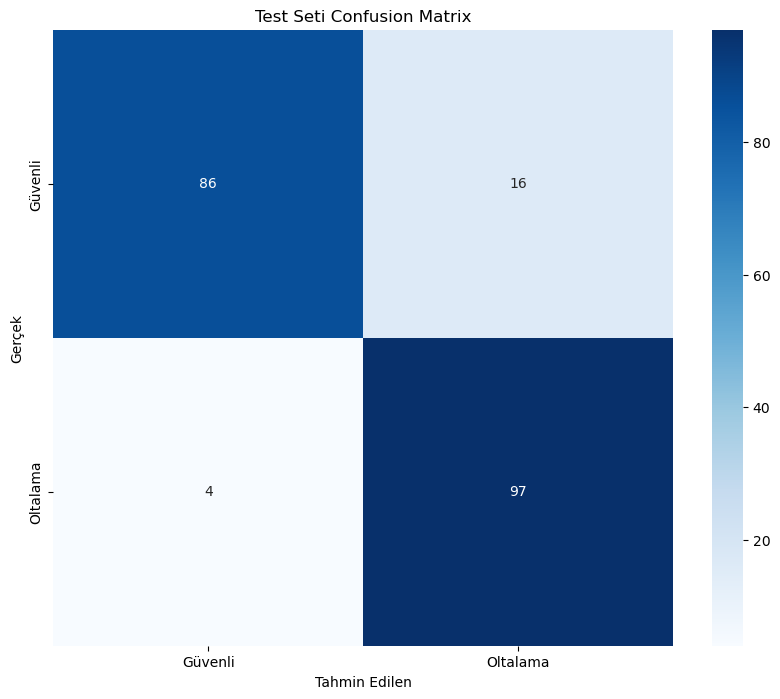


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 86
False Positives (Güvenli yanlış tahmin): 16
False Negatives (Oltalama yanlış tahmin): 4
True Positives (Oltalama doğru tahmin): 97

Model parametreleri: {'hidden_layer_sizes': (150, 100, 50), 'activation': 'tanh', 'solver': 'adam', 'max_iter': 2000, 'learning_rate_init': 0.01, 'batch_size': 128, 'early_stopping': True}

CV metrikleri:
cv_accuracy_mean: 0.9260
cv_accuracy_std: 0.0101
cv_precision_mean: 0.9253
cv_precision_std: 0.0447
cv_recall_mean: 0.9344
cv_recall_std: 0.0438
cv_f1_mean: 0.9278
cv_f1_std: 0.0083

Test metrikleri:
test_accuracy: 0.9015
test_precision: 0.8584
test_recall: 0.9604
test_f1: 0.9065

En iyi model kaydedildi:
Model: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/mlp/turkish_mlp.joblib
Vectorizer: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/mlp/turkish_tfidf.joblib
En iyi parametreler: {'hidden_layer_siz

In [54]:
model_dir = os.path.join(os.path.dirname(os.getcwd()),"source", "models", "mlp")
# Modeli eğit
best_model, best_vectorizer = train_and_evaluate_mlp(
    train_data=train_df,
    test_data=test_df,
    dataset_name="turkish",
    experiment_name=experiment_name,
    out_dir=model_dir,
    mlp_params=mlp_params
)

## DNN Türkçe Modeli

Türkçe veri seti ile DNN modeli eğitilir. 

Validation Metrikleri
| Metrik Türü | Accuracy | Precision | Recall | F1 Score |
|-------------|----------|-----------|--------|----------|
| Değer | 0.9262 | 0.9333 | 0.9180 | 0.9256 |

Test Metrikleri
| Metrik Türü | Accuracy | Precision | Recall | F1 Score |
|-------------|----------|-----------|--------|----------|
| Değer | 0.9113 | 0.8879 | 0.9406 | 0.9135 |

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import mlflow
import mlflow.keras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib
import os
def train_and_evaluate_dnn(train_data, val_data, test_data, dataset_name,
                          experiment_name, out_dir, text_column='text'):
    """
    DNN modelini eğitir, değerlendirir ve sonuçları kaydeder.
    """
    # MLflow deneyini ayarla
    try:
        experiment = mlflow.get_experiment_by_name(experiment_name)
        if experiment is None:
            mlflow.create_experiment(experiment_name)
        mlflow.set_experiment(experiment_name)
    except Exception as e:
        print(f"MLflow ayarlanırken hata oluştu: {e}")
    
    with mlflow.start_run(run_name=f"DNN_{dataset_name}"):
        vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
        X_train = vectorizer.fit_transform(train_data[text_column]).toarray()
        X_val = vectorizer.transform(val_data[text_column]).toarray()
        X_test = vectorizer.transform(test_data[text_column]).toarray()
        
        model = keras.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(1, activation='sigmoid')
    ])
        
        model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
        
        # Early stopping
        early_stopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
        
        # Model eğitimi
        history = model.fit(
            X_train, train_data['labels'],
            epochs=100,
            batch_size=32,
            validation_data=(X_val, val_data['labels']),
            callbacks=[early_stopping]
        )
        
        val_pred = (model.predict(X_val) > 0.5).astype(int)
        test_pred = (model.predict(X_test) > 0.5).astype(int)
        
        val_metrics = {
            'val_accuracy': accuracy_score(val_data['labels'], val_pred),
            'val_precision': precision_score(val_data['labels'], val_pred),
            'val_recall': recall_score(val_data['labels'], val_pred),
            'val_f1': f1_score(val_data['labels'], val_pred)
        }
        
        test_metrics = {
            'test_accuracy': accuracy_score(test_data['labels'], test_pred),
            'test_precision': precision_score(test_data['labels'], test_pred),
            'test_recall': recall_score(test_data['labels'], test_pred),
            'test_f1': f1_score(test_data['labels'], test_pred)
        }
        
        # MLflow'a parametreleri ve metrikleri kaydet
        mlflow.log_params({
            "dataset": dataset_name,
            "architecture": "DNN",
            "max_features": 5000,
            "ngram_range": "(1,2)"
        })
        mlflow.log_metrics({**val_metrics, **test_metrics})
        
        # Modeli kaydet
        os.makedirs(out_dir, exist_ok=True)
        model_path = os.path.join(out_dir, f"{dataset_name}_dnn.h5")
        vectorizer_path = os.path.join(out_dir, f"{dataset_name}_dnn_tfidf.joblib")
        
        model.save(model_path)
        joblib.dump(vectorizer, vectorizer_path)
        
        # MLflow'a modeli kaydet
        mlflow.keras.log_model(model, "model")
        
        # Confusion matrix'leri görselleştir ve kaydet
        plot_and_log_confusion_matrix(
            val_data['labels'],
            val_pred,
            'Validation Seti Confusion Matrix',
            os.path.join(out_dir, "validation_confusion_matrix.png")
        )
        
        plot_and_log_confusion_matrix(
            test_data['labels'],
            test_pred,
            'Test Seti Confusion Matrix',
            os.path.join(out_dir, "test_confusion_matrix.png")
        )
        
        # Sonuçları yazdır
        print(f"\nValidation metrikleri:")
        for metric, value in val_metrics.items():
            print(f"{metric}: {value:.4f}")
            
        print(f"\nTest metrikleri:")
        for metric, value in test_metrics.items():
            print(f"{metric}: {value:.4f}")
        
    return model, vectorizer, val_pred, test_pred


In [42]:
dnn_train_data, dnn_val_data = train_test_split(train_df, test_size=0.15, random_state=42)


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5200 - loss: 0.9198 - val_accuracy: 0.5000 - val_loss: 0.6874
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7963 - loss: 0.4344 - val_accuracy: 0.5000 - val_loss: 0.6714
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9028 - loss: 0.2502 - val_accuracy: 0.7213 - val_loss: 0.6432
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9251 - loss: 0.1891 - val_accuracy: 0.7377 - val_loss: 0.6136
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9647 - loss: 0.1197 - val_accuracy: 0.8115 - val_loss: 0.5771
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9876 - loss: 0.0598 - val_accuracy: 0.8525 - val_loss: 0.5436
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9822 - loss: 0.0552 - val_accuracy: 0.8770 - val_loss: 0.5134
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9881 - loss: 0.0592 - val_accuracy: 0.9016 - 

2025/01/05 00:34:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/01/05 00:34:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


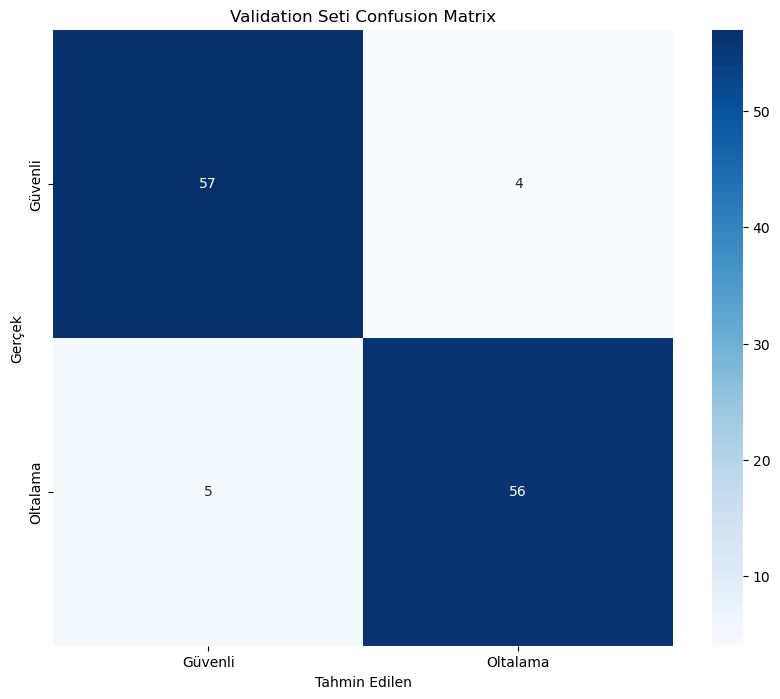


Validation Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 57
False Positives (Güvenli yanlış tahmin): 4
False Negatives (Oltalama yanlış tahmin): 5
True Positives (Oltalama doğru tahmin): 56


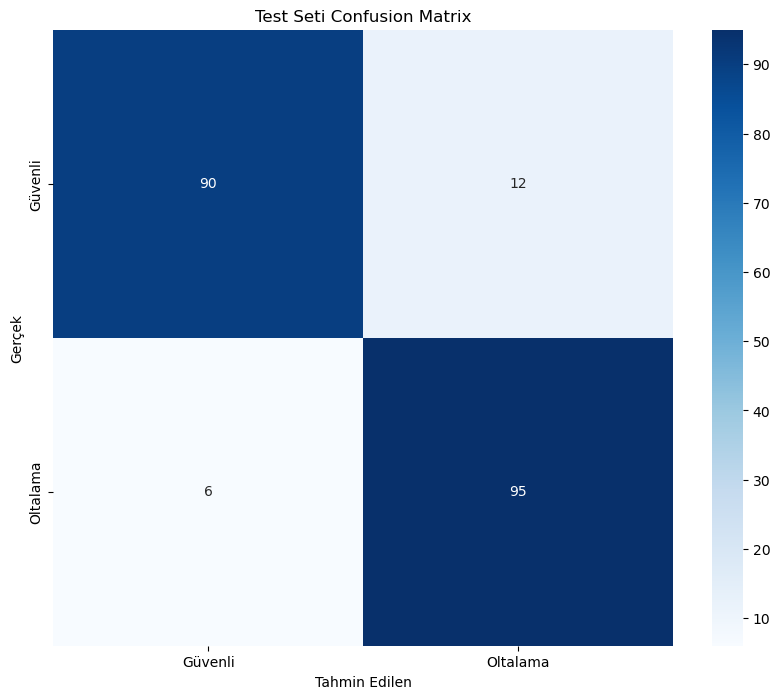


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 90
False Positives (Güvenli yanlış tahmin): 12
False Negatives (Oltalama yanlış tahmin): 6
True Positives (Oltalama doğru tahmin): 95

Validation metrikleri:
val_accuracy: 0.9262
val_precision: 0.9333
val_recall: 0.9180
val_f1: 0.9256

Test metrikleri:
test_accuracy: 0.9113
test_precision: 0.8879
test_recall: 0.9406
test_f1: 0.9135


In [43]:
model_dir = os.path.join(os.path.dirname(os.getcwd()),"source", "models", "dnn", "turkish")
model, vectorizer, val_pred, test_pred =train_and_evaluate_dnn(dnn_train_data,
                                                               dnn_val_data, 
                                                               test_df, 
                                                               "turkish",
                                                                "turkish_dnn_demo", 
                                                                model_dir)

### Naive Bayes Türkçe Modeli

Parametreler:

| alpha | fit_prior |
|-------|-----------|
| 1.0 | False |


Başarım sonuçları:

CV Sonuçları
|  | Accuracy | Precision | Recall | F1 Score |
|-----------------|----------|-----------|--------|----------|
| Ortalama | 0.9248 | 0.9682 | 0.8810 | 0.9224 |
| Standart Sapma | 0.0062 | 0.0103 | 0.0145 | 0.0069 |

Test Sonuçları
|  | Accuracy | Precision | Recall | F1 Score |
|-------------|----------|-----------|--------|----------|
| Değer | 0.9261 | 0.9479 | 0.9010 | 0.9239 |


In [70]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import mlflow
import mlflow.sklearn
import joblib
import os

def train_and_evaluate_nb(train_data, test_data, dataset_name,
                         experiment_name, out_dir, nb_params, text_column='text'):
    """
    Naive Bayes modelini eğitir, değerlendirir ve sonuçları kaydeder.
    """
    try:
        experiment = mlflow.get_experiment_by_name(experiment_name)
        if experiment is None:
            mlflow.create_experiment(experiment_name)
        mlflow.set_experiment(experiment_name)
    except Exception as e:
        print(f"MLflow ayarlanırken hata oluştu: {e}")
    
    # En iyi TF-IDF parametreleri
    tfidf_params = {
        'max_features': 5000,
        'ngram_range': (1, 2)
    }
    
    best_test_f1 = 0
    best_model = None
    best_vectorizer = None
    best_params = None

    os.makedirs(out_dir, exist_ok=True)
    for params in nb_params:
        with mlflow.start_run(run_name=f"NaiveBayes_{dataset_name}"):
            pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(**tfidf_params)),
                ('nb', MultinomialNB(**params))
            ])
            
            cv_scores = cross_validate(pipeline, 
                                     train_data[text_column], 
                                     train_data['labels'],
                                     cv=5,
                                     scoring=['accuracy', 'precision', 'recall', 'f1'])
            
            pipeline.fit(train_data[text_column], train_data['labels'])
            
            test_pred = pipeline.predict(test_data[text_column])
            
            cv_metrics = {
                'cv_accuracy_mean': cv_scores['test_accuracy'].mean(),
                'cv_accuracy_std': cv_scores['test_accuracy'].std(),
                'cv_precision_mean': cv_scores['test_precision'].mean(),
                'cv_precision_std': cv_scores['test_precision'].std(),
                'cv_recall_mean': cv_scores['test_recall'].mean(),
                'cv_recall_std': cv_scores['test_recall'].std(),
                'cv_f1_mean': cv_scores['test_f1'].mean(),
                'cv_f1_std': cv_scores['test_f1'].std()
            }
            
    
            test_metrics = {
                'test_accuracy': accuracy_score(test_data['labels'], test_pred),
                'test_precision': precision_score(test_data['labels'], test_pred),
                'test_recall': recall_score(test_data['labels'], test_pred),
                'test_f1': f1_score(test_data['labels'], test_pred)
            }
            
            # MLflow'a parametreleri ve metrikleri kaydet
            mlflow.log_params({
                "dataset": dataset_name,
                **params,
                **tfidf_params
            })
            
            if test_metrics['test_f1'] > best_test_f1:
                best_test_f1 = test_metrics['test_f1']
                best_model = pipeline['nb']
                best_vectorizer = pipeline['tfidf']
                best_params = params
            
        
            
            plot_and_log_confusion_matrix(
                test_data['labels'],
                test_pred,
                'Test Seti Confusion Matrix',
                os.path.join(out_dir, f"test_confusion_matrix_nb.png")
            )
            
            print(f"\nModel parametreleri: {params}")
            print("\nCV metrikleri:")
            for metric, value in cv_metrics.items():
                print(f"{metric}: {value:.4f}")
        
            print(f"\nTest metrikleri:")
            for metric, value in test_metrics.items():
                print(f"{metric}: {value:.4f}")
    
    model_path = os.path.join(out_dir, f"{dataset_name}_nb.joblib")
    vectorizer_path = os.path.join(out_dir, f"{dataset_name}_tfidf.joblib")
    
    joblib.dump(best_model, model_path)
    joblib.dump(best_vectorizer, vectorizer_path)
    
    print(f"\nEn iyi model kaydedildi:")
    print(f"Model: {model_path}")
    print(f"Vectorizer: {vectorizer_path}")
    print(f"En iyi parametreler: {best_params}")
    
    return best_model, best_vectorizer

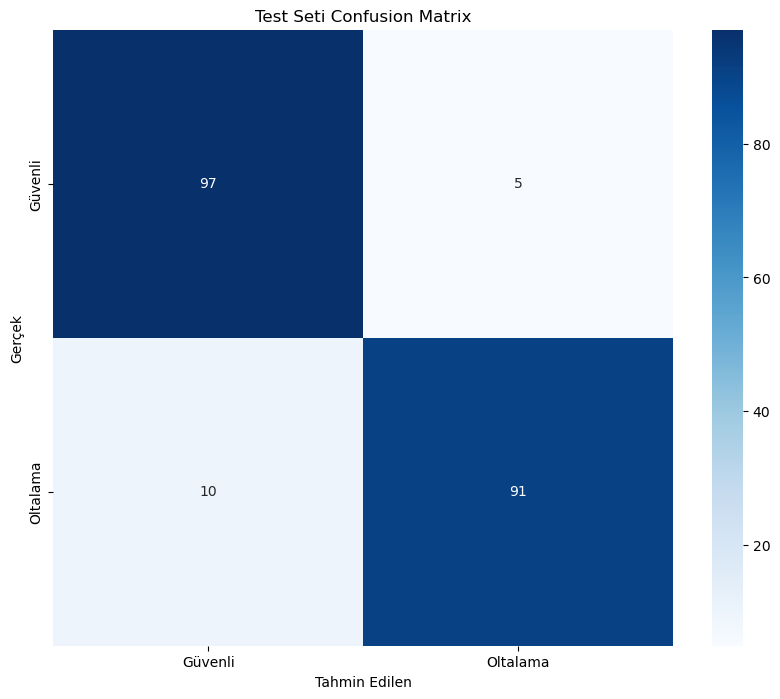


Test Seti Confusion Matrix
True Negatives (Güvenli doğru tahmin): 97
False Positives (Güvenli yanlış tahmin): 5
False Negatives (Oltalama yanlış tahmin): 10
True Positives (Oltalama doğru tahmin): 91

Model parametreleri: {'alpha': 1.0, 'fit_prior': False}

CV metrikleri:
cv_accuracy_mean: 0.9248
cv_accuracy_std: 0.0062
cv_precision_mean: 0.9682
cv_precision_std: 0.0103
cv_recall_mean: 0.8810
cv_recall_std: 0.0145
cv_f1_mean: 0.9224
cv_f1_std: 0.0069

Test metrikleri:
test_accuracy: 0.9261
test_precision: 0.9479
test_recall: 0.9010
test_f1: 0.9239

En iyi model kaydedildi:
Model: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/naive_bayes/turkish/turkish_nb.joblib
Vectorizer: /Users/tczeuslu/Desktop/zgu/courses/data_mining/phishing-mail-detection/src/source/models/naive_bayes/turkish/turkish_tfidf.joblib
En iyi parametreler: {'alpha': 1.0, 'fit_prior': False}


In [71]:
model_dir = os.path.join(os.path.dirname(os.getcwd()),"source", "models", "naive_bayes", "turkish")

nb_params = [
    {'alpha': 1.0, 'fit_prior': False}
]
best_model, best_vectorizer = train_and_evaluate_nb(
    train_data=train_df,
    test_data=test_df,
    dataset_name="turkish",
    experiment_name="turkish_nb_demo",
    out_dir=model_dir,
    nb_params=nb_params
)